In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series
from matplotlib.backends.backend_pdf import PdfPages
warnings.filterwarnings('ignore')


In [5]:
# Read the first xlsx file
netpres = pd.read_csv('NPR_RPT_NetPres_Fact.csv')
waze = pd.read_csv('NPR_STG_Waze_MLink_Attribs.csv')
webeoc = pd.read_csv('NPR_STG_WebEOC_MLink_Attribs.csv')
tomtom = pd.read_csv('NPR_STG_TomTomIncidents_MLink_Attribs.csv')

In [6]:
netpres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280320 entries, 0 to 280319
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MLink_VersionID            280320 non-null  int64  
 1   MLinkID                    280320 non-null  int64  
 2   LocalDate                  280320 non-null  object 
 3   LocalTime                  280320 non-null  object 
 4   SpeedKmh                   280320 non-null  float64
 5   Speed_Method               280320 non-null  int64  
 6   VolumeCount                280320 non-null  int64  
 7   Volume_Method              280320 non-null  int64  
 8   Flow                       280320 non-null  int64  
 9   CostOfDelay                280320 non-null  float64
 10  CostOfReliability          0 non-null       float64
 11  CostOfVehicleOperation     280320 non-null  float64
 12  CostOfAdditionalEmissions  280320 non-null  float64
 13  CostOfCongestion           27

In [7]:
webeoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   665 non-null    int64  
 1   MLinkId              663 non-null    float64
 2   FirstDateTime        665 non-null    object 
 3   LastDateTime         665 non-null    object 
 4   Location             665 non-null    object 
 5   TrafficImpact        665 non-null    object 
 6   IncidentType         665 non-null    object 
 7   IsClosed             665 non-null    int64  
 8   TrafficCondition     665 non-null    object 
 9   Road                 665 non-null    object 
 10  Region               665 non-null    object 
 11  IncidentLevel        665 non-null    object 
 12  Suburb               665 non-null    object 
 13  Longitude            665 non-null    float64
 14  Latitude             665 non-null    float64
 15  NonMappingReason     2 non-null      obj

In [8]:
import pandas as pd

def add_incident_count(df, df2):
    """
    Add an IncidentCount column to the original DataFrame based on incident occurrences in df2.

    Parameters:
        df (DataFrame):
            Original DataFrame containing the LocalDateTime column.
        df2 (DataFrame):
            DataFrame containing the incident information and TimeOfTheIncident column.

    Returns:
        DataFrame:
            Modified DataFrame with the IncidentCount column added.
    """
    # Convert LocalDateTime and TimeOfTheIncident to datetime
    df['LocalDate'] = pd.to_datetime(df['LocalDate'])
    df2['FirstDateTime'] = pd.to_datetime(df2['FirstDateTime'])

    # Group incidents in df2 by date and count occurrences
    incident_counts = df2.groupby(df2['FirstDateTime'].dt.date)['IncidentType'].count().reset_index()
    incident_counts.columns = ['Date', 'IncidentCount']

    # Merge incident counts with df
    df['Date'] = df['LocalDate'].dt.date
    df = pd.merge(df, incident_counts, on='Date', how='left')

    # Fill NaN values in IncidentCount column with 0
    df['IncidentCount'].fillna(0, inplace=True)

    # Drop the temporary 'Date' column
    df.drop(columns=['Date'], inplace=True)

    return df

# Example usage:
# modified_df = add_incident_count(df, df2)


In [9]:
modified_df = add_incident_count(netpres[netpres['MLinkID'] == 721], webeoc[webeoc['MLinkId'] == 721])
modified_df.head()

,MLink_VersionID,MLinkID,LocalDate,LocalTime,SpeedKmh,Speed_Method,VolumeCount,Volume_Method,Flow,CostOfDelay,CostOfReliability,CostOfVehicleOperation,CostOfAdditionalEmissions,CostOfCongestion,BOM_Rainfallmm,TravelTimeVariabilityCost,LoadDateTime,WindowStart,DW_ModifiedDateTime,IncidentCount
0,72120220120114522,721,2023-01-01,00:00:00,96.357238,17,146,65536,584,0.0,NaN,0.0,0.0,0.46251,NaN,0.46250,2023-02-10 10:21:16.053,2023-01-01 00:00:00 +00:00,2023-02-10 10:21:16.053,0.0
1,72120220120114522,721,2023-01-01,00:15:00,96.840287,17,205,65536,820,0.0,NaN,0.0,0.0,0.62609,NaN,0.62609,2023-02-10 10:21:16.053,2023-01-01 00:00:00 +00:00,2023-02-10 10:21:16.053,0.0
2,72120220120114522,721,2023-01-01,00:30:00,96.730078,17,261,65536,1044,0.0,NaN,0.0,0.0,2.85374,NaN,2.85374,2023-02-10 10:21:16.053,2023-01-01 00:00:00 +00:00,2023-02-10 10:21:16.053,0.0
3,72120220120114522,721,2023-01-01,00:45:00,80.147779,17,291,65536,1164,0.0,NaN,0.0,0.0,6.38081,NaN,6.38081,2023-02-10 10:21:16.053,2023-01-01 00:00:00 +00:00,2023-02-10 10:21:16.053,0.0
4,72120220120114522,721,2023-01-01,01:00:00,90.585868,17,287,65536,1148,0.0,NaN,0.0,0.0,1.79285,NaN,1.79285,2023-02-10 10:21:16.053,2023-01-01 00:00:00 +00:00,2023-02-10 10:21:16.053,0.0


In [10]:
def plot_volume_time_for_day_of_week2(df, pdf_pages):
    """
    Plot VolumeCount on y-axis and TimeOfDay on x-axis for each day of the week.

    Parameters:
        df (DataFrame):
            DataFrame containing the data.
        pdf_pages (PdfPages):
            PdfPages object to save the plots to PDF.
    """
    df = df[df['IncidentCount'] > 0]
    # Convert LocalTime to time
    df['LocalTime'] = pd.to_datetime(df['LocalTime'])

    # Extract month and day from LocalDateTime column
    df['month'] = df['LocalDate'].dt.month
    df['day'] = df['LocalDate'].dt.day
    df['day_of_week'] = df['LocalDate'].dt.day_name()

    # Group data by day of the week
    day_groups = df.groupby('day_of_week')

    # Map day of the week names to corresponding indexes (0: Monday, 1: Tuesday, ..., 6: Sunday)
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_indexes = {day: i for i, day in enumerate(day_names)}

    # Iterate over each day of the week
    for day, day_data in day_groups:
        # Create a new figure for the subplots
        fig, axs = plt.subplots(4, 3, figsize=(15, 15))
        fig.suptitle(f'VolumeCount for {day}', fontsize=16)
        axs = axs.flatten()  # Flatten the 2D array of subplots for easier iteration

        # Iterate over each month
        for i, (month, month_data) in enumerate(day_data.groupby('month')):
            # Plot VolumeCount vs TimeOfDay for the specified month and day of the week
            ax = axs[i]
            for j in range(1, 32):  # Assume maximum 31 days in a month
                # Filter data for the specified day and month
                day_month_data = month_data[month_data['day'] == j]
                if not day_month_data.empty:
                    # Extract TimeOfDay from LocalDateTime
                    #day_month_data['TimeOfDay'] = day_month_data['LocalDateTime'].dt.time
                    day_month_data['TimeOfDay'] = day_month_data['LocalTime'].dt.hour + day_month_data['LocalTime'].dt.minute / 60
                    ax.plot(day_month_data['TimeOfDay'], day_month_data['VolumeCount'], label=f'Day {j}')
            
            ax.set_title(month)
            ax.set_xlabel('Time of Day')
            ax.set_ylabel('VolumeCount')
            ax.legend()

        # Save the subplot to the PDF
        pdf_pages.savefig(fig)
        plt.close(fig)  # Close the figure to release memory



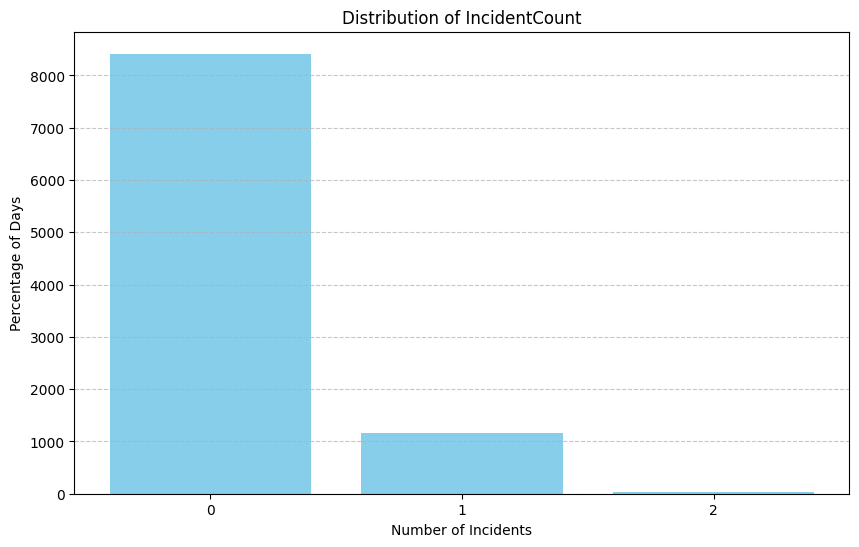

In [11]:
import matplotlib.pyplot as plt

def plot_incident_count_distribution(df):
    """
    Plot the distribution of IncidentCount as a bar chart.

    Parameters:
        df (DataFrame):
            DataFrame containing the IncidentCount column.
    """
    # Count occurrences of each IncidentCount
    incident_count_counts = df['IncidentCount'].value_counts().sort_index()

    # Calculate the total number of days
    total_days = len(df['LocalDate'].dt.date.unique())

    # Calculate the percentage of days for each IncidentCount
    percentage_days = (incident_count_counts / total_days) * 100

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(percentage_days.index, percentage_days.values, color='skyblue')
    plt.title('Distribution of IncidentCount')
    plt.xlabel('Number of Incidents')
    plt.ylabel('Percentage of Days')
    plt.xticks(range(len(percentage_days.index)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
plot_incident_count_distribution(modified_df)


In [12]:
import matplotlib.pyplot as plt

def plot_rainy_vs_non_rainy_days_bar(df):
    """
    Plot a bar chart of rainy vs non-rainy days for the entire DataFrame.

    Parameters:
        df (DataFrame):
            DataFrame containing the rainfall information.
    """
    # Calculate percentage of rainy days
    rainy_days_percentage = (df['BOM_Rainfallmm'] > 0).mean() * 100
    non_rainy_days_percentage = 100 - rainy_days_percentage

    # Plot bar chart
    plt.figure(figsize=(6, 6))
    plt.bar(['Rainy Days', 'Non-Rainy Days'], [rainy_days_percentage, non_rainy_days_percentage], color=['skyblue', 'orange'])
    plt.title('Rainy vs Non-Rainy Days')
    plt.ylabel('Percentage')
    plt.ylim(0, 100)

    # Annotate exact percentage numbers on the chart
    for i, percentage in enumerate([rainy_days_percentage, non_rainy_days_percentage]):
        plt.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

    plt.show()



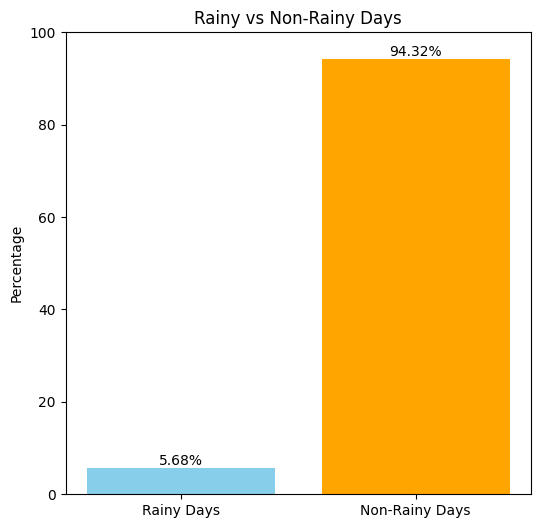

In [13]:

# Example usage:
plot_rainy_vs_non_rainy_days_bar(netpres)

In [14]:
netpres.describe()['SpeedKmh']

count    280320.000000
mean         91.690770
std          15.099328
min           5.039076
25%          93.705686
50%          96.470918
75%          98.274262
max         122.016537
Name: SpeedKmh, dtype: float64

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_speed_distribution(df):
    """
    Visualize the distribution of the 'SpeedKmh' column in the DataFrame.

    Parameters:
        df (DataFrame):
            DataFrame containing the 'SpeedKmh' column.
    """
    # Create subplots
    fig, axs = plt.subplots(3, figsize=(10, 15))

    # Box plot
    sns.boxplot(df['SpeedKmh'], ax=axs[0])
    axs[0].set_title('Box Plot')

    # Histogram
    sns.histplot(df['SpeedKmh'], bins=20, kde=False, ax=axs[1])
    axs[1].set_title('Histogram')

    # Density plot
    sns.kdeplot(df['SpeedKmh'], ax=axs[2])
    axs[2].set_title('Density Plot')

    plt.tight_layout()
    plt.show()



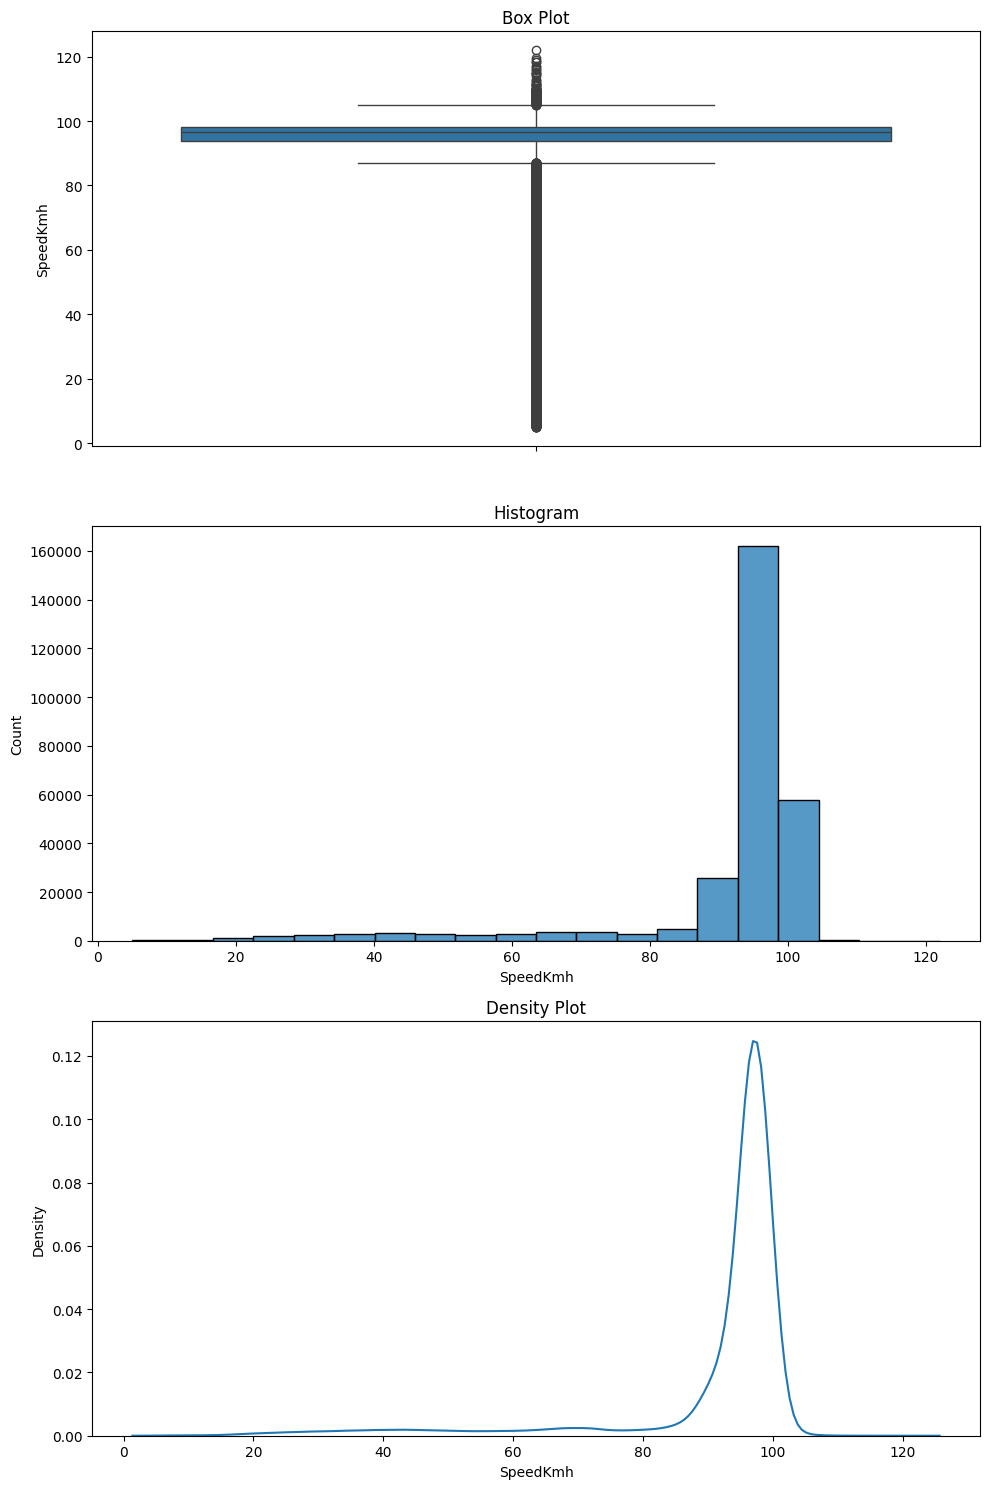

In [16]:
# Example usage:
visualize_speed_distribution(netpres)


In [17]:
waze.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73759 entries, 0 to 73758
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   73759 non-null  object 
 1   MLinkId              59770 non-null  float64
 2   FirstDateTimeLocal   73759 non-null  object 
 3   LastDateTimeLocal    73759 non-null  object 
 4   City                 58377 non-null  object 
 5   Reliability          73759 non-null  int64  
 6   AlertType            73759 non-null  object 
 7   AlertSubType         70999 non-null  object 
 8   Street               71789 non-null  object 
 9   Longitude            73759 non-null  float64
 10  Latitude             73759 non-null  float64
 11  NonMappingReason     13989 non-null  object 
 12  DW_ModifiedDateTime  73759 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 7.3+ MB


In [18]:
netpres['LocalDate'] = pd.to_datetime(netpres['LocalDate'])

In [19]:
hols=pd.read_excel('WA Public Holidays 2023.xlsx')
wa=hols[hols['Jurisdiction'] == 'wa']

In [20]:
netpres['public_holiday'] = netpres['LocalDate'].isin(wa['Date']).astype(int)
netpres['public_holiday'].value_counts()

public_holiday
0    271104
1      9216
Name: count, dtype: int64

In [21]:
import datetime
with open('2023 weekends.txt', 'r') as file:
    weekends = file.read().split(',')

weekends = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in weekends]

In [22]:
import datetime

# Convert the dates in the 'LocalDate' column to datetime objects
netpres['LocalDate'] = pd.to_datetime(netpres['LocalDate'])

# Create a binary column 'weekend' to indicate whether a given row is a weekend or not
netpres['weekend'] = netpres['LocalDate'].dt.date.isin([date.date() for date in weekends]).astype(int)

In [23]:
netpres['weekend'].value_counts()

weekend
0    199680
1     80640
Name: count, dtype: int64

In [24]:
netpres_cpy=netpres[['MLinkID','LocalDate','LocalTime','SpeedKmh','VolumeCount','BOM_Rainfallmm','public_holiday','weekend']]
df3=netpres_cpy.loc[netpres_cpy['MLinkID']==719]
df3=df3.drop(['MLinkID'],axis=1)
df3['LocalDateTime'] = pd.to_datetime(df3['LocalDate'].astype(str) + ' ' + df3['LocalTime'].astype(str))
df3=df3.drop(['LocalDate','LocalTime'],axis=1)
df3=df3[['LocalDateTime',
         'VolumeCount',
         'SpeedKmh', 
 'BOM_Rainfallmm',
 'public_holiday',
 'weekend']]
df3['BOM_Rainfallmm'] = df3['BOM_Rainfallmm'].fillna(0)
df3 = df3.sort_values(by='LocalDateTime')
df3=df3.reset_index(drop=True)
df3.tail()

,LocalDateTime,VolumeCount,SpeedKmh,BOM_Rainfallmm,public_holiday,weekend
35035,2023-12-31 22:45:00,354,96.293826,0.0,0,1
35036,2023-12-31 23:00:00,274,96.232424,0.0,0,1
35037,2023-12-31 23:15:00,253,95.637832,0.0,0,1
35038,2023-12-31 23:30:00,179,94.826578,0.0,0,1
35039,2023-12-31 23:45:00,122,96.524784,0.0,0,1


In [25]:
# Group data by desired factors and convert to time series
groups = df3.groupby(df3['LocalDateTime'].dt.date)
time_series = []
for group_name, group_data in groups:
    time_series.append(group_data[['VolumeCount', 'SpeedKmh', 'BOM_Rainfallmm']].values)

# Convert to 3D NumPy array
X = to_time_series(time_series)

print(X.shape)  # Output should be (number_of_time_series, length_of_each_time_series, number_of_features)


(365, 96, 3)


In [26]:
from tslearn.clustering import TimeSeriesKMeans

def apply_kmeans(X, metric='euclidean', n_clusters=8, random_state=None):
    """
    Apply KMeans clustering on time series data.

    Parameters:
        X (array-like, shape=(n_samples, n_timestamps, n_features)):
            Time series data to cluster.
        metric (str, optional):
            The distance metric to use for clustering. Default is 'euclidean'.
            Other options include 'dtw' (dynamic time warping), 'softdtw' (soft dynamic time warping),
            'sbd' (squared binary divergence), 'kld' (Kullback-Leibler divergence), 'dtw_sakoechiba' 
            (DTW with Sakoe-Chiba constraint), 'dtw_itakura' (DTW with Itakura constraint).
        n_clusters (int, optional):
            The number of clusters to form. Default is 8.
        random_state (int, RandomState instance or None, optional):
            Determines random number generation for centroid initialization. 
            Pass an int for reproducible results across multiple function calls. Default is None.

    Returns:
        labels (array-like, shape=(n_samples,)):
            Cluster labels for each time series.
    """
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, random_state=random_state)
    labels = kmeans.fit_predict(X)
    return labels


In [27]:
import numpy as np

# Step 1: Cluster the Time Series Data
labels = apply_kmeans(X, metric='dtw', n_clusters=5, random_state=42)

# Step 2: Expand Cluster Labels
expanded_labels = np.repeat(labels, X.shape[1])

# Step 3: Map Cluster Labels to Original Data
df3['cluster_label'] = expanded_labels

In [28]:
import calendar

def compute_day_of_week_percentage(df):
    """
    Compute the percentage of each day of the week in each cluster.

    Parameters:
        df (DataFrame):
            DataFrame containing the cluster labels and datetime information.

    Returns:
        day_of_week_percentages (DataFrame):
            DataFrame containing the percentage of each day of the week in each cluster.
    """
    # Count of each day of the week in each cluster
    day_of_week_counts = df.groupby(['cluster_label', df['LocalDateTime'].dt.dayofweek]).size()

    # Total count of data points in each cluster
    total_counts = df['cluster_label'].value_counts()

    # Percentage of each day of the week in each cluster
    day_of_week_percentages = (day_of_week_counts / total_counts).unstack(fill_value=0) * 100

    # Convert day of week index to actual day names
    day_of_week_percentages.columns = [calendar.day_name[i] for i in range(7)]

    return day_of_week_percentages

# Example usage:
# day_of_week_percentages = compute_day_of_week_percentage(df)
# print(day_of_week_percentages)


In [29]:
# Example usage:
day_of_week_percentages = compute_day_of_week_percentage(df3)
print(day_of_week_percentages)

                  Monday    Tuesday  Wednesday   Thursday     Friday  \
cluster_label                                                          
0              15.151515  21.212121  21.212121   6.060606  15.151515   
1               4.273504   3.418803   1.709402   2.564103   5.982906   
2              26.666667  25.185185  20.000000  27.407407   0.740741   
3              20.000000  10.000000  30.000000   0.000000  40.000000   
4               5.714286   8.571429  18.571429  14.285714  50.000000   

                Saturday     Sunday  
cluster_label                        
0              12.121212   9.090909  
1              41.025641  41.025641  
2               0.000000   0.000000  
3               0.000000   0.000000  
4               0.000000   2.857143  


In [30]:
import matplotlib.pyplot as plt
import calendar

def plot_cluster_day_of_week_bar(df, day_of_week_percentages):
    """
    Plot bar charts for each cluster, where each bar represents the percentages of the day of the week.

    Parameters:
        df (DataFrame):
            DataFrame containing the cluster labels and datetime information.
        day_of_week_percentages (DataFrame):
            DataFrame containing the percentage of each day of the week in each cluster.
    """
    # Determine the number of clusters
    n_clusters = df['cluster_label'].nunique()

    # Create subplots for each cluster
    fig, axs = plt.subplots(n_clusters, figsize=(10, 6 * n_clusters))

    # Plot bar chart for each cluster
    for cluster_label, ax in zip(range(n_clusters), axs):
        # Get percentages for the cluster
        percentages = day_of_week_percentages.loc[cluster_label].sort_values(ascending=False)

        # Plot bar chart
        ax.bar(percentages.index, percentages.values, color='skyblue')
        ax.set_title(f'Cluster {cluster_label + 1}')
        ax.set_xlabel('Day of Week')
        ax.set_ylabel('Percentage')
        ax.set_ylim(0, 60)
        ax.set_xticks(range(len(calendar.day_abbr)))
        ax.set_xticklabels(calendar.day_abbr)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_cluster_day_of_week_bar(df, day_of_week_percentages)


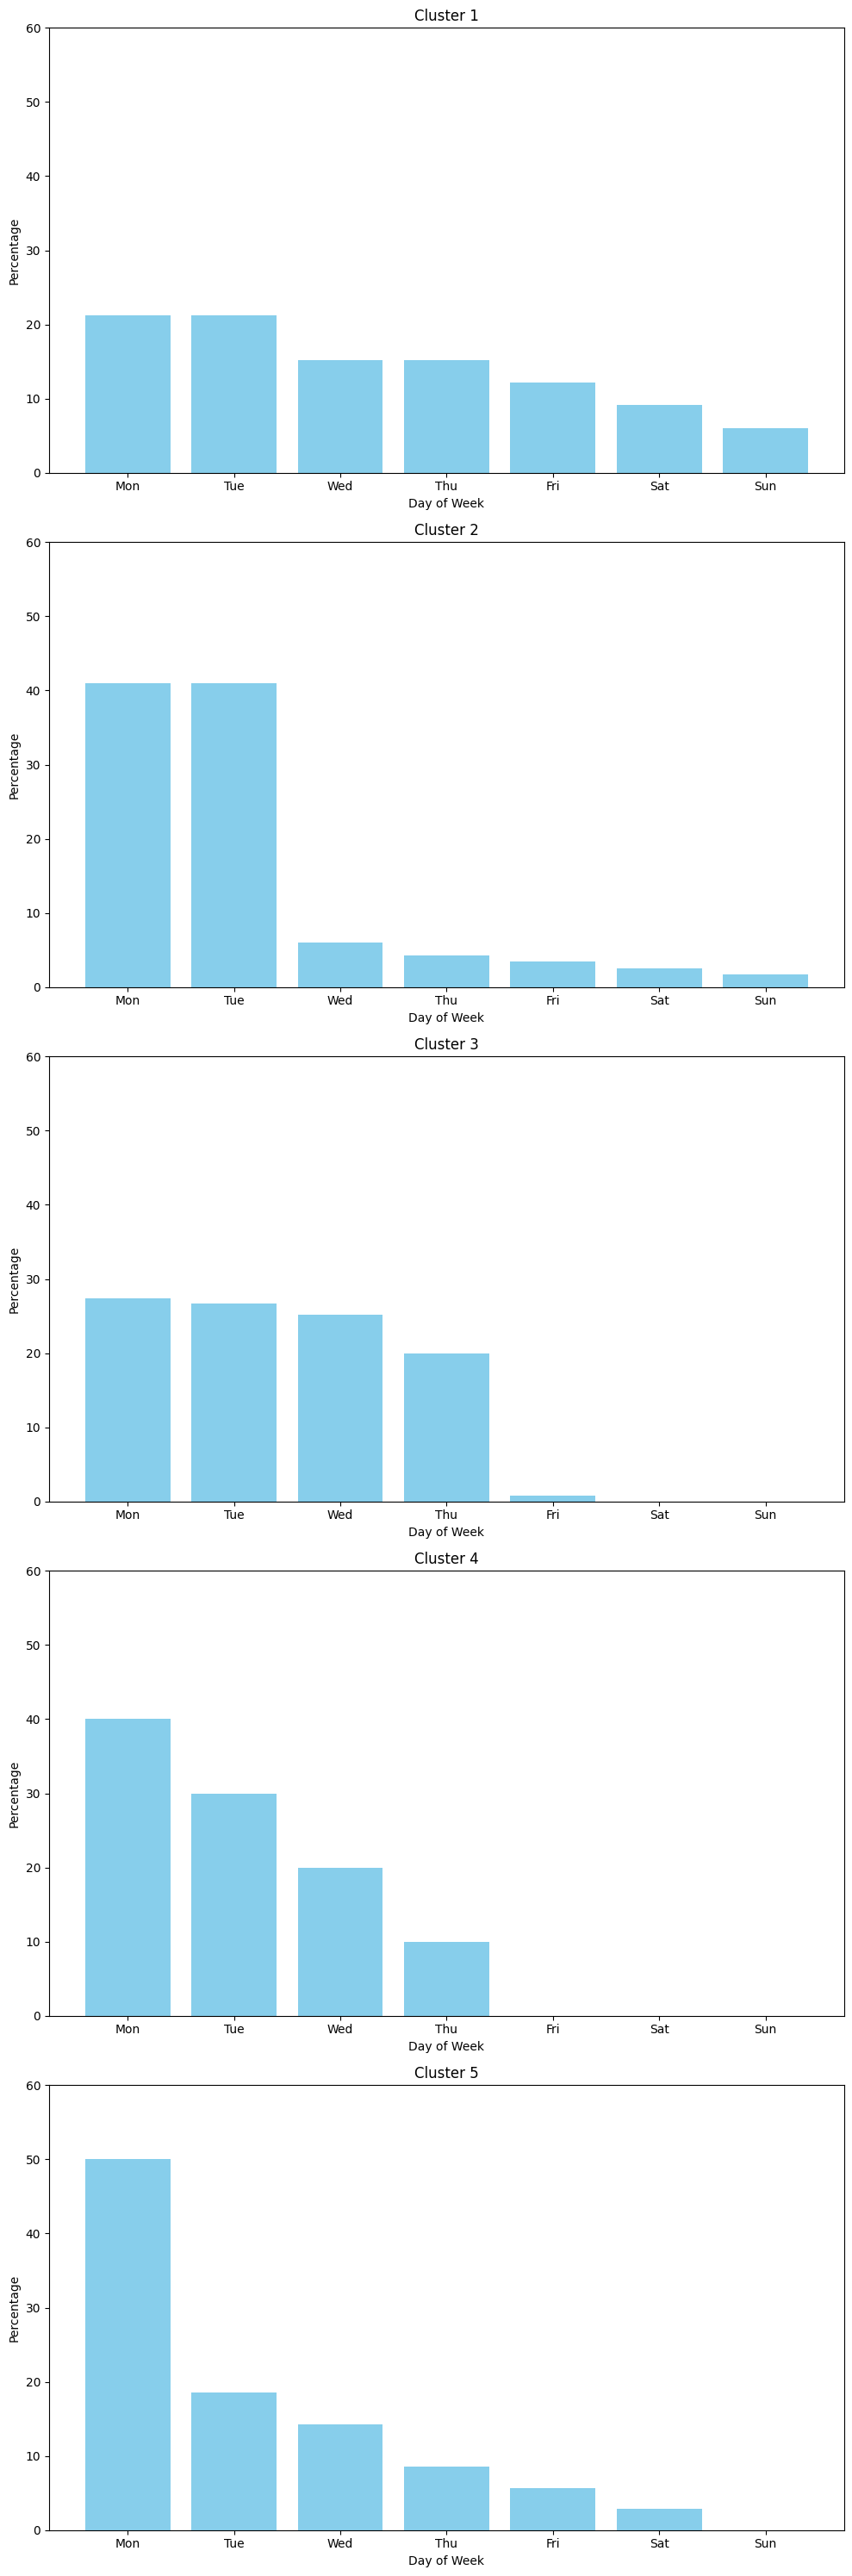

In [31]:
# Example usage:
plot_cluster_day_of_week_bar(df3, day_of_week_percentages)


In [32]:
import matplotlib.pyplot as plt

def plot_cluster_volume_time(df):
    """
    Plot volume on the y-axis and time of the day on the x-axis for each cluster.

    Parameters:
        df (DataFrame):
            DataFrame containing the cluster labels and datetime information.
    """
    # Determine the number of clusters
    n_clusters = df['cluster_label'].nunique()

    # Create subplots for each cluster
    fig, axs = plt.subplots(n_clusters, figsize=(10, 6 * n_clusters), sharex=True)

    # Plot volume vs. time for each cluster
    for cluster_label, ax in zip(range(n_clusters), axs):
        cluster_df = df[df['cluster_label'] == cluster_label]

        # Extract hour and minute from LocalDateTime
        cluster_df['Hour'] = cluster_df['LocalDateTime'].dt.hour
        cluster_df['Minute'] = cluster_df['LocalDateTime'].dt.minute

        # Filter data to include only the time range 00:00 to 23:45
        cluster_df = cluster_df[(cluster_df['Hour'] == 0) & (cluster_df['Minute'] == 0) |
                                ((cluster_df['Hour'] < 23) | (cluster_df['Minute'] <= 45))]

        # Plot volume vs. time
        ax.plot(cluster_df['Hour'] + cluster_df['Minute'] / 60, cluster_df['VolumeCount'])
        ax.set_title(f'Cluster {cluster_label + 1}')
        ax.set_xlabel('Time of Day (hours)')
        ax.set_ylabel('Volume')
        ax.set_xlim(0, 24)  # Set x-axis limit from 0 to 24 hours
        ax.grid(True)

    plt.tight_layout()
    plt.show()

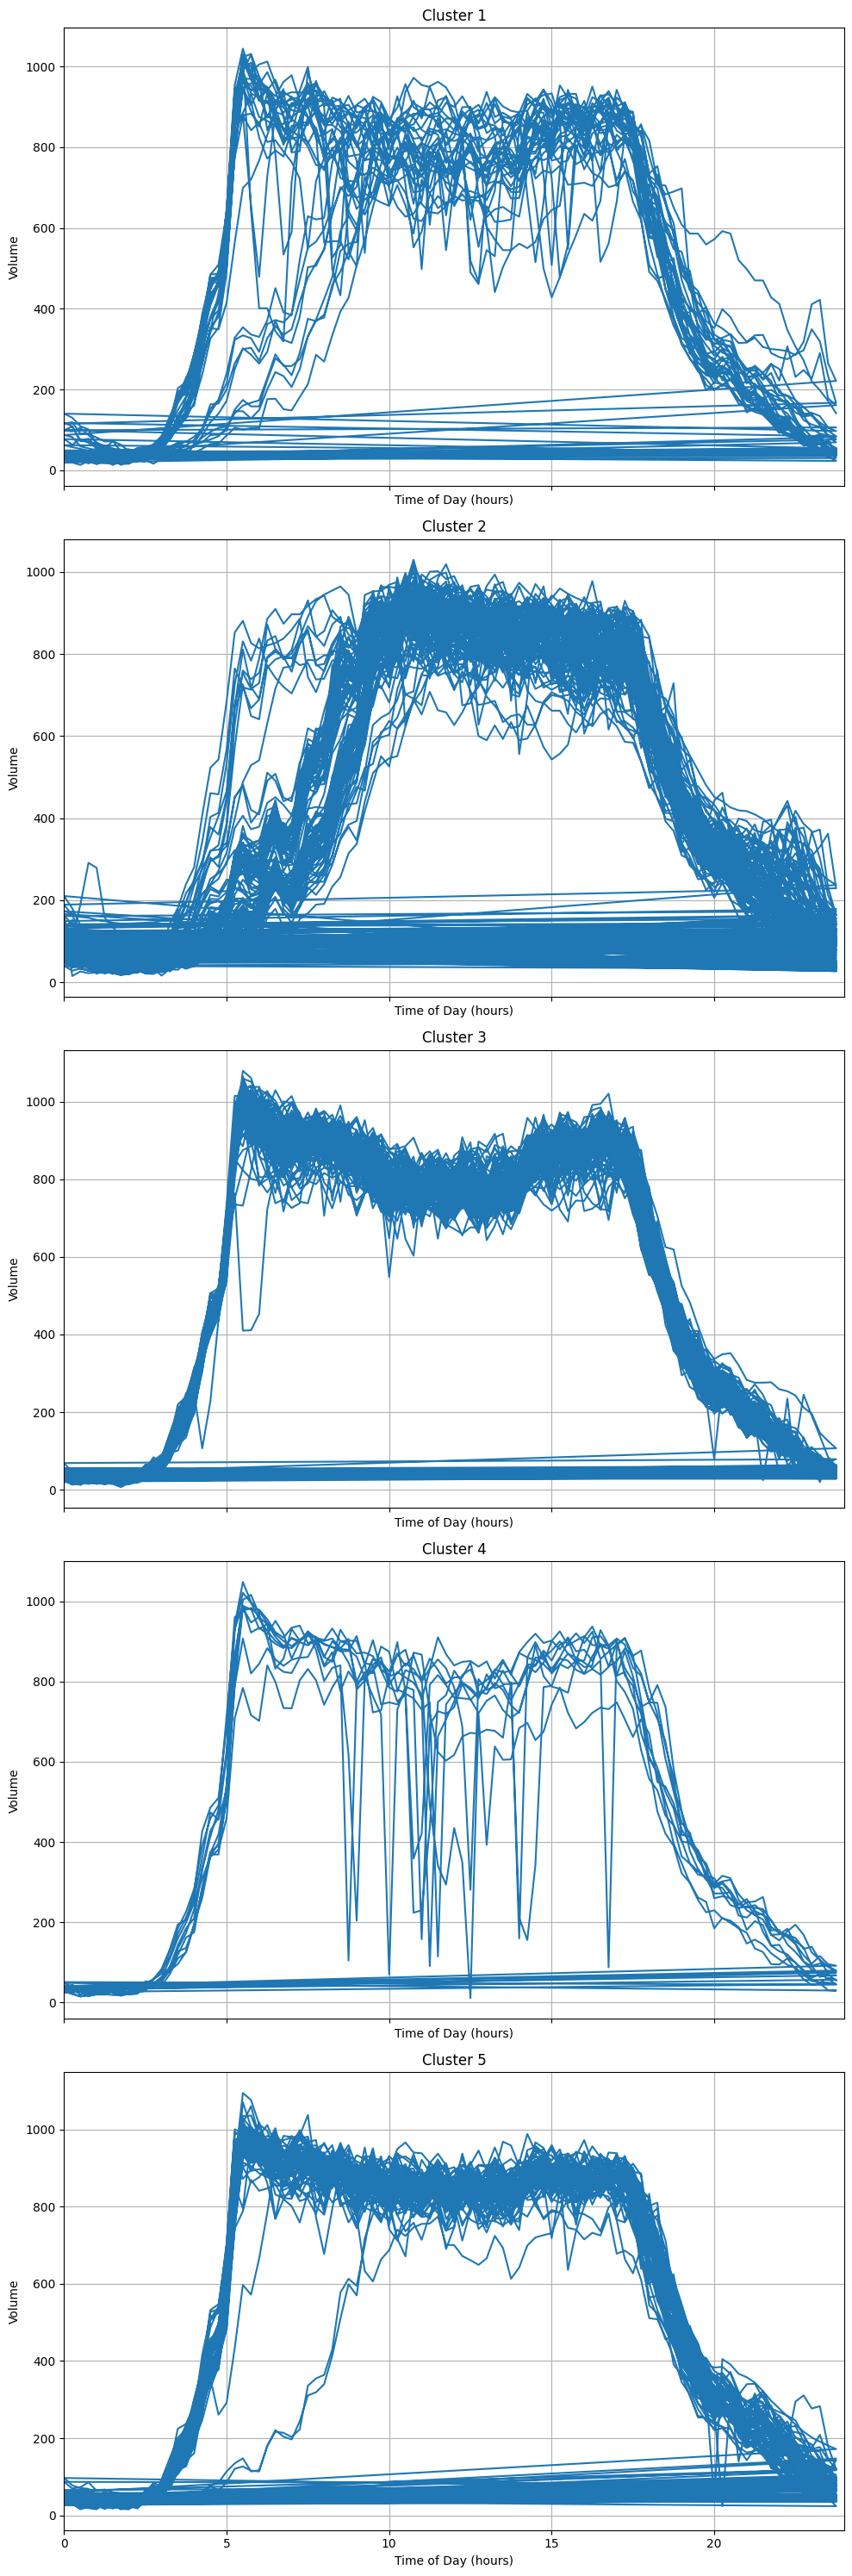

In [33]:
plot_cluster_volume_time(df3)


In [34]:
df3[df3['VolumeCount'].astype(int) < 200]

,LocalDateTime,VolumeCount,SpeedKmh,BOM_Rainfallmm,public_holiday,weekend,cluster_label
0,2023-01-01 00:00:00,87,97.554298,0.0,1,1,1
1,2023-01-01 00:15:00,104,96.401469,0.0,1,1,1
2,2023-01-01 00:30:00,189,96.140468,0.0,1,1,1
5,2023-01-01 01:15:00,157,95.592399,0.0,1,1,1
6,2023-01-01 01:30:00,135,95.820000,0.0,1,1,1
...,...,...,...,...,...,...,...
34971,2023-12-31 06:45:00,165,99.417984,0.0,0,1,1
34972,2023-12-31 07:00:00,159,98.832023,0.0,0,1,1
34973,2023-12-31 07:15:00,192,100.326740,0.0,0,1,1
35038,2023-12-31 23:30:00,179,94.826578,0.0,0,1,1


In [35]:
import matplotlib.pyplot as plt

def plot_cluster_volume_lt200_time(df):
    """
    Plot volume on the y-axis and time of the day on the x-axis for each cluster.

    Parameters:
        df (DataFrame):
            DataFrame containing the cluster labels and datetime information.
    """
    # Determine the number of clusters
    n_clusters = df['cluster_label'].nunique()

    # Create subplots for each cluster
    fig, axs = plt.subplots(n_clusters, figsize=(10, 6 * n_clusters), sharex=True)

    # Plot volume vs. time for each cluster
    for cluster_label, ax in zip(range(n_clusters), axs):
        cluster_df = df[df['cluster_label'] == cluster_label]

        # Extract hour and minute from LocalDateTime
        cluster_df['Hour'] = cluster_df['LocalDateTime'].dt.hour
        cluster_df['Minute'] = cluster_df['LocalDateTime'].dt.minute

        # Filter data to include only the time range 00:00 to 23:45
        cluster_df = cluster_df[(cluster_df['Hour'] == 0) & (cluster_df['Minute'] == 0) |
                                ((cluster_df['Hour'] < 23) | (cluster_df['Minute'] <= 45))]
        cluster_df = cluster_df[cluster_df['VolumeCount'].astype(int) < 200]
        
        # Plot volume vs. time
        ax.plot(cluster_df['Hour'] + cluster_df['Minute'] / 60, cluster_df['VolumeCount'])
        ax.set_title(f'Cluster {cluster_label + 1}')
        ax.set_xlabel('Time of Day (hours)')
        ax.set_ylabel('Volume')
        ax.set_xlim(0, 24)  # Set x-axis limit from 0 to 24 hours
        ax.grid(True)

    plt.tight_layout()
    plt.show()


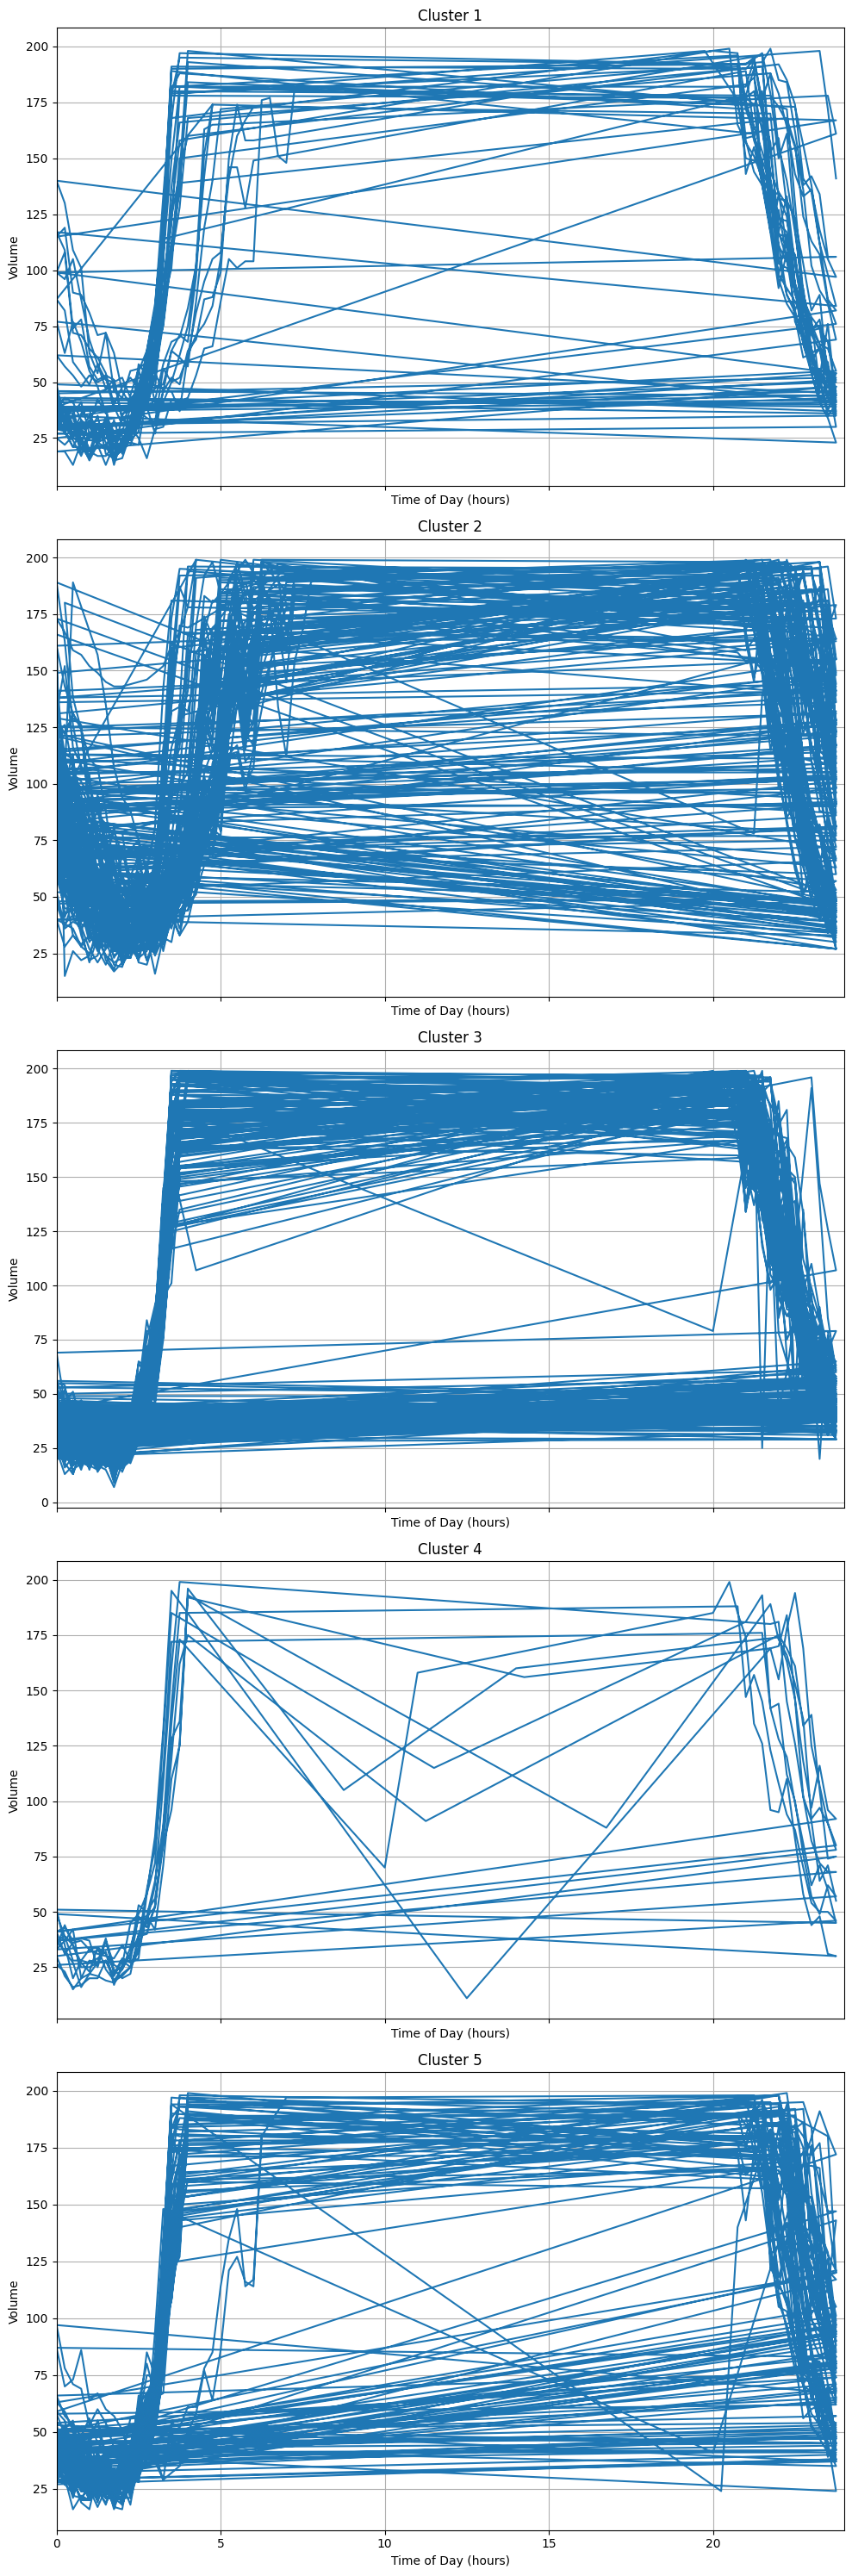

In [36]:

# Example usage:
plot_cluster_volume_lt200_time(df3)

In [37]:
import matplotlib.pyplot as plt

def plot_cluster_public_holiday_bar(df):
    """
    Plot bar charts for each cluster, where each subplot contains two bars representing the percentage of data points
    on public holidays and non-public holidays.

    Parameters:
        df (DataFrame):
            DataFrame containing the cluster labels and public holiday information.
    """
    # Determine the number of clusters
    n_clusters = df['cluster_label'].nunique()

    # Create subplots for each cluster
    fig, axs = plt.subplots(n_clusters, figsize=(10, 6 * n_clusters))

    # Plot bar chart for each cluster
    for cluster_label, ax in zip(range(n_clusters), axs):
        cluster_df = df[df['cluster_label'] == cluster_label]

        # Calculate percentage of data points on public holidays and non-public holidays
        public_holiday_percent = (cluster_df['public_holiday'].sum() / len(cluster_df)) * 100
        non_public_holiday_percent = 100 - public_holiday_percent

        # Plot bar chart
        ax.bar(['Public Holiday', 'Non-Public Holiday'], [public_holiday_percent, non_public_holiday_percent], color=['skyblue', 'lightgreen'])
        ax.set_title(f'Cluster {cluster_label + 1}')
        ax.set_ylabel('Percentage')
        ax.set_ylim(0, 100)

        # Annotate exact percentage numbers on the chart
        for i, percentage in enumerate([public_holiday_percent, non_public_holiday_percent]):
            ax.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')


    plt.tight_layout()
    plt.show()


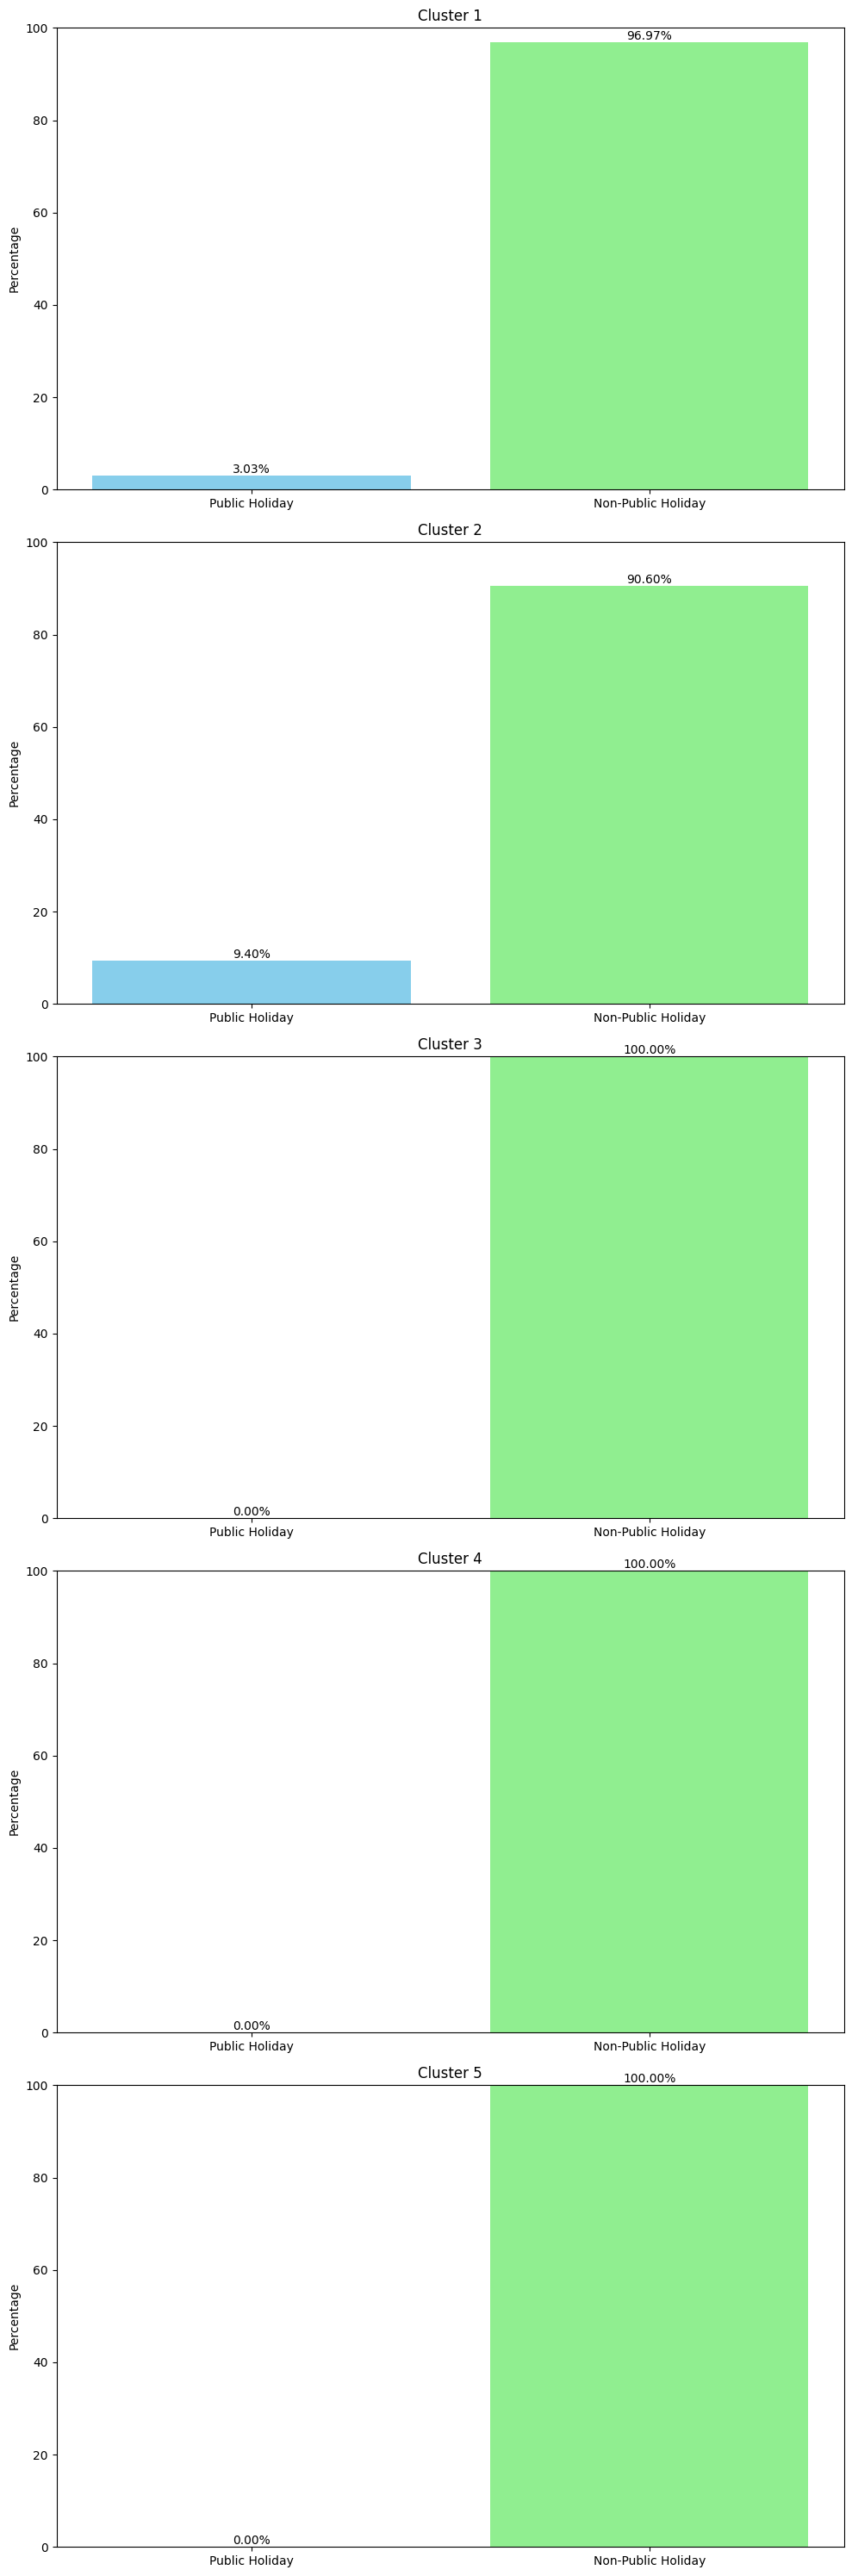

In [38]:
# Example usage:
plot_cluster_public_holiday_bar(df3)

In [39]:
import matplotlib.pyplot as plt

def plot_cluster_rainy_days_bar(df):
    """
    Plot bar charts for each cluster, where each bar represents the percentage of rainy days.

    Parameters:
        df (DataFrame):
            DataFrame containing the cluster labels and rainfall information.
    """
    # Determine the number of clusters
    n_clusters = df['cluster_label'].nunique()

    # Create subplots for each cluster
    fig, axs = plt.subplots(n_clusters, figsize=(10, 6 * n_clusters))

    # Plot bar chart for each cluster
    for cluster_label, ax in zip(range(n_clusters), axs):
        cluster_df = df[df['cluster_label'] == cluster_label]

        # Calculate percentage of rainy days
        rainy_days_percentage = (cluster_df['BOM_Rainfallmm'] > 0).mean() * 100

        # Plot bar chart
        ax.bar(['Rainy Days', 'Non-Rainy Days'], [rainy_days_percentage, 100 - rainy_days_percentage], color=['skyblue', 'orange'])
        ax.set_title(f'Cluster {cluster_label + 1}')
        ax.set_ylabel('Percentage')
        ax.set_ylim(0, 100)

        # Annotate exact percentage numbers on the chart
        for i, percentage in enumerate([rainy_days_percentage, 100 - rainy_days_percentage]):
            ax.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


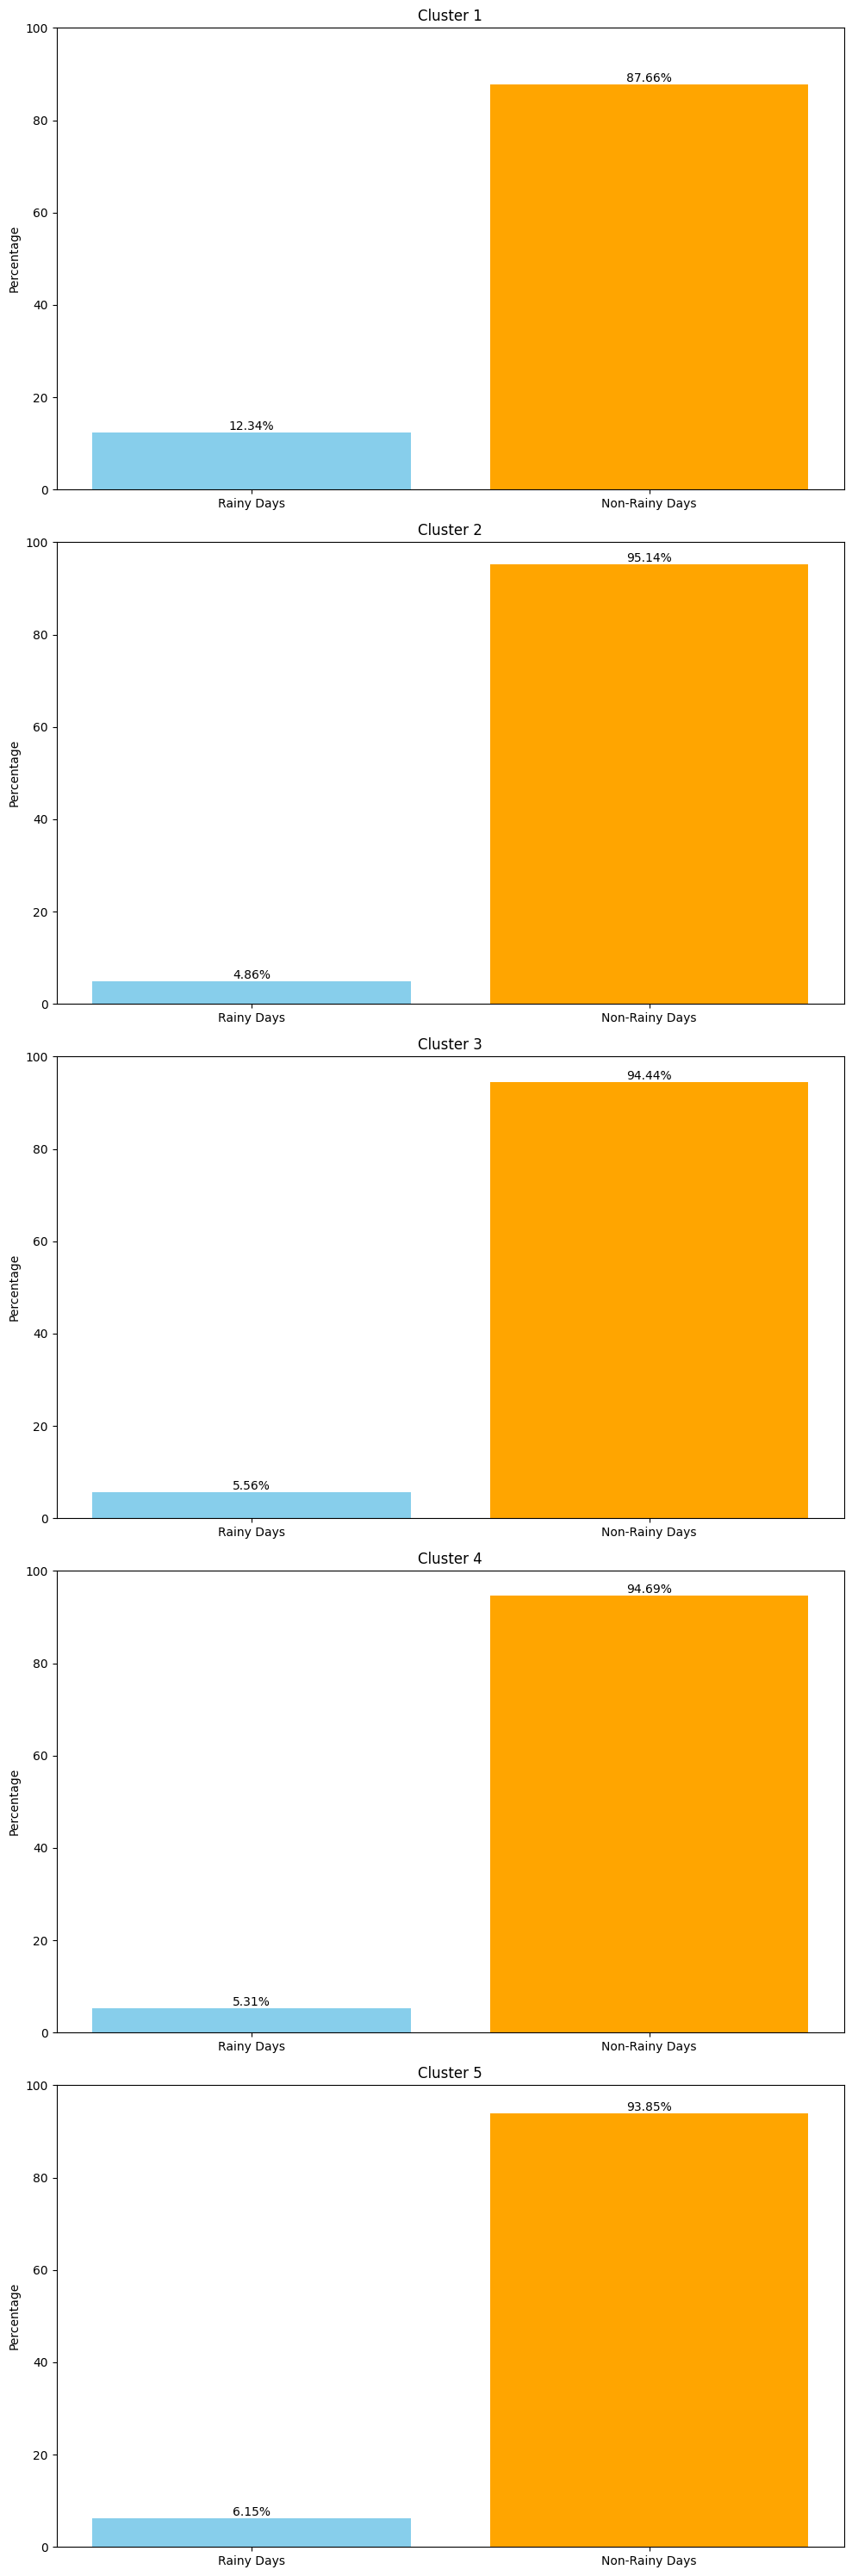

In [40]:

# Example usage:
plot_cluster_rainy_days_bar(df3)


In [41]:
int(3.20192)

3